# **Geopotential classifier  for rain forecasting**

The aim of the project is to recognize potential rainy situations from bidimensional geopotential distributions at three fundamental pressure heights. Geopotential is the work per mass unit needed to move air to a certain height starting from the sea level. Geopotential patterns are strictly related to the precipitation at the ground, since they give information about frontogenesis and wind developments.
In the project, the combination of the maps at the three heights represent the instat synoptic situation of the geographic region considered, thus each map is treated as a primary colour of a single image and therefore a 2D convolutional neural network is implemented.

## **Preliminar operations**
This notebook requires some non-standard packages for geophysical data handling such as:

*   netCDF4
*   Folium
*   geojsoncontour

If you are running this local, please make sure that they are installed in your environment.

For a faster execution, CUDA is used. 

### **Settings**
Here the main parameters for the data and the network are set.

The *perc_lim* parmeter defines the fraction of the dataset identified as non-rainy situations. This selection is necessary since the occurrence of rain is not a binary process, but a threshold process. The threshold is indirectly derived from the fraction of non rainy-days selected afterwards in the program.

The *architecture* parameter defines the architecture chosen for the current run. Two different architectures are implemented in the program.
Check *Architecture* section for further information.

In [1]:
# Where are you running this notebook ['local' or 'colab']?
running = 'colab'

# Settings for dataset importation
perc_limit = 95   # of non-rainy days
years = 1521      # years = {starting_year}{ending_year}
locality = 'to'   # Possibilities -> to (Turin) - lon (London)

# Settings for dataset splitting
train_val_splitting = 0.2   # 0.2 for pre-trained models
val_test_splitting = 0.5    # 0.5 for pre-trained models

# Settings for the network
architecture = 'custom' # Possibilities -> report, custom
re_train = False        # If tou want to train the net again, set to True.
                        # For the list of pre-trained models, run the following cell.
                        # Setting False will load the pre-trained models and print
                        # the results.

# Settings for the training
epochs = 30
epochs_for_validation = 1

In [2]:
# Some stuff for colab and gdrive
if running == 'colab':
    # Mounting drive for dataset extrapolation
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive/My\ Drive/ML

print('\nPRETRAINED MODELS')
print('Models have been trained over 2015-2021')
print('Read as model_{architecture}_perc{perc_lim}_{locality}')
%ls 'models'

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1EcVsbwezTEttRBMK6ZkrDLQMYy4oNpzw/ML

PRETRAINED MODELS
Models have been trained over 2015-2021
Read as model_{architecture}_perc{perc_lim}_{locality}
model_custom_perc59_lon_Andrea.pth  model_report_perc59_lon_Andrea.pth
model_custom_perc59_to.pth          model_report_perc59_to.pth
model_custom_perc70_to.pth          model_report_perc70_to.pth
model_custom_perc80_lon_Andrea.pth  model_report_perc80_to.pth
model_custom_perc80_to_Andrea.pth   model_report_perc84_to.pth
model_custom_perc80_to.pth          model_report_perc90_to.pth
model_custom_perc84_to.pth          model_report_perc95_to.pth
model_custom_perc90_to_Andrea.pth   model_report_perc98_to.pth
model_custom_perc90_to.pth          old/
model_custom_perc95_to.pth          Vari/
model_custom_perc98_to.pth


### **Importations**

In [3]:
%%capture
# Some stuff for colab and gdrive
if running == 'colab':
    !pip install folium pandas
    !pip install geojsoncontour

# Standard importations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importations for dataset handling
import netCDF4 as nc

# Some tools for preparing data
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Torch for building and training the network
import torch
from torchvision.transforms import Compose, ToTensor, ColorJitter, RandomHorizontalFlip
from torch.nn import Linear, Conv2d, MaxPool2d, Softmax, ReLU, CrossEntropyLoss, AvgPool2d, BatchNorm2d, Sigmoid
from torch.optim import SGD, Adam, Adagrad
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

# A package for the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Some tools for displaying geophyisical data
from PIL import Image
import folium
from folium import plugins
import geojsoncontour

# A neat progress bar
from tqdm.notebook import tqdm


In [4]:
# Checking that your environment is OK with CUDA
if torch.cuda.is_available()== True:
    print('CUDA avaiable')
else:
    raise SystemExit("Stop right there, you need CUDA!")

CUDA avaiable


## Importing and preparing data
Data are imported from ERA5, which is the fifth generation ECMWF atmospheric reanalysis of the global climate covering the period from January 1950 to present. ERA5 provides hourly estimates of a large number of atmospheric, land and oceanic climate variables. The data cover the Earth on a 30km grid.

### **Getting labels**
The perc_lim variable introduced before is now used to define the threshold for the precipitation. The dataset is now divided in (perc_lim)% non-rain and (1 - perc_lim)% rain. The threshold derives directly from this subdivision.

In [5]:
def get_from_era5_prec(loc, years):
    
    '''
    This function opens the .nc dataset, extracts precipitations and cumulates
    them over 6 hours
    '''

    database = nc.Dataset(f'Dataset/prec_{loc}_{years}.nc')
    dataset = database['tp'][:]
    database.close()
    
    prec = []
    for start, end in zip(range(0, dataset.shape[0], 6), range(6, dataset.shape[0]+6, 6)):
        prec.append(dataset[start:end].sum()*1000)
    
    return np.array(prec)


# Taking precipitations from ERA5
rain_mm = get_from_era5_prec(locality, years)

# Defining threshold on perc_limit
threshold = np.percentile(rain_mm, perc_limit)

# Instantiate the binarizer object by defining the threshold we want
binarizer = Binarizer(threshold=threshold)

# Run the binarizer on our data and save the output
rain_bin = binarizer.fit_transform(rain_mm.reshape(rain_mm.shape[0], 1))
print(rain_bin.shape)

print('Threshold value: ',threshold)
print('No Rain/Rain labels ')
print(np.bincount(rain_bin[:,0].astype(int)))
print(np.bincount(rain_bin[:,0].astype(int))/rain_bin.shape[0])

# Theese are our labels
labels = rain_bin

del rain_bin

(2404, 1)
Threshold value:  3.68154410878758
No Rain/Rain labels 
[2283  121]
[0.94966722 0.05033278]


### **Getting geopotential fields**
The geopotential maps need some sort of normalization. The standardization of each maps is not a good choice, since the geopotential has a general trend of higher vlues in the equator direction and lower values in the poles direction. The normalization chosen here is the standardization (normalization with anomaly) of each grid point respect to the climatological mean and standard deviation of same the grid point. This means that the mean and the standard deviation are calculated on the evolution the grid point through the dataset.
This process is done for every pressure height (every color of the image).

**Note**: it is legit to speak about climatological mean only for a dataset spanning 30 years of data or more. With shorter dataset, the standardization loses its climatological sense.

In [6]:
def get_from_era5_fields(param, level, years):

    '''
    This function opens the .nc dataset, extracts geopotential fields and 
    normalize them with anomaly
    '''
    
    # Importing database
    database = nc.Dataset(f'Dataset/{param}_{level}_{years}.nc')
    
    # Extracting geopotential
    dataset = database[param][:]
    
    # Closing database
    database.close()
    
    # Normalizing with anomaly
    dataset -= dataset.mean(axis=0)
    dataset /= dataset.std(axis=0)
    
    return np.array(dataset, dtype=np.float32)


# Defining levels and parameters for fields'
parameters = ['z','z','z'] # Pressure heights
levels = [500,700,850] # hPa

data = []
# Iterate over the parrallel arrays "parameters" and 'levels' together
for parameter, level in zip(parameters, levels):
    
    # Append extracted data to array
    data.append(get_from_era5_fields(parameter, level, years))

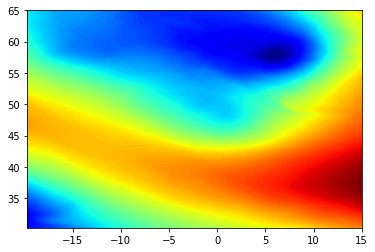

In [7]:
# Plot a random map for rain (700 hpa)
r_to = np.where(labels == 1)
index_rain = np.random.choice(r_to[0])

lon = np.arange(-19.75, 15.1, 0.25)
lat = np.arange(30.25, 65.1, 0.25)

geojson = geojsoncontour.contourf_to_geojson(
    contourf=plt.contourf(lon,lat,data[1][index_rain,:,:],len(data[1][index_rain,:,:]),cmap=plt.cm.jet),
    fill_opacity=1)

geomap1 = folium.Map([49,0], zoom_start=4, tiles="stamenterrain")

folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.4,
    }).add_to(geomap1)

plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap1)

geomap1

### **Preparing data**
For data splittinig in Train, Validation and Test set, the random state is fixed for reproducibility. 

In [8]:
# Concatenate the images along 1 axis
data = np.stack(data, axis=1)

if labels.shape[0] != data.shape[0]:
    print("Wait, something's wrong, you should re-generate 'data' before going on")

# Split main data into train-test
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, random_state = 7, test_size=train_val_splitting)
# Split test data into train-validation
data_val, data_test, labels_val, labels_test = train_test_split(data_test, labels_test, random_state = 7, test_size=val_test_splitting)

print('TRAINING SET')
print(f'Size:\t{labels_train.shape[0]}\train labels:\t{(labels_train == 1).sum()}')
print('VALIDATION SET')
print(f'Size:\t{labels_val.shape[0]}\train labels:\t{(labels_val == 1).sum()}')
print('TEST SET')
print(f'Size:\t{labels_test.shape[0]}\train labels:\t{(labels_test == 1).sum()}')

del data

TRAINING SET
Size:	1923	rain labels:	93
VALIDATION SET
Size:	240	rain labels:	20
TEST SET
Size:	241	rain labels:	8


In [9]:
# This section contains some operations for torch
class CustomDataset(Dataset):
    
    def __init__(self, images, labels):
        
        self.images = images
        self.labels = labels
        self.to_tensor = Compose([ToTensor()])


    def __getitem__(self, index):
        # Get the images and labels at the index the DataLoader is asking
        image, label = self.images[index], self.labels[index]

        # Return images and labels converted to torch.tensor types 
        return torch.tensor(image).float(), torch.tensor(label[0]).long()

    # This function is used automatically by torch.DataLoader to know how many images we have, so that
    # he can pass the correct index to __getitem__ and don't go out-of-bounds
    def __len__(self):

        return(len(self.images))


# Now we declare an object of the class we just defined
ds_train = CustomDataset(data_train, labels_train)
ds_val = CustomDataset(data_val, labels_val)
ds_test = CustomDataset(data_test, labels_test)

# The DataLoader gets 'dataset' as input
dl_train = DataLoader(ds_train, batch_size=32, drop_last=True, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=16, drop_last=True, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=16, drop_last=True, shuffle=True)

del ds_train
del ds_val
del ds_test

## **The network**

### **Architecture**
Two different architectures have been implemented. Report (from P.R. Larrondo et al, 2017) which is short and fat, and our network, deeper and thinner. 

In [10]:
# Network from the report (short and fat)
class report_fat(torch.nn.Module):
    def __init__(self):
        super(report_fat, self).__init__()
        self.conv1 = Conv2d(3, 128, 3)
        self.pool1 = MaxPool2d(2)
        self.conv2 = Conv2d(128, 256, 3)
        self.pool2 = MaxPool2d(2)
      
        self.fc1 = Linear(278784, 2)
        #self.soft = Softmax()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc1(x)
        #   x = self.soft(x)
        
        return x

# Our network (taller and thin)
class custom_thin(torch.nn.Module):
    def __init__(self):
        super(custom_thin, self).__init__()
        self.conv1 = Conv2d(3, 8, kernel_size=9, padding = 4, stride = 1)
        self.relu1 = ReLU()
        self.batchnorm1 = BatchNorm2d(8)
        self.pool1 = AvgPool2d(2)
        self.conv2 = Conv2d(8, 16, kernel_size=7, padding = 3, stride = 1)
        self.relu2 = ReLU()
        self.batchnorm2 = BatchNorm2d(16)
        self.pool2 = AvgPool2d(2)
        self.conv3 = Conv2d(16, 32, kernel_size=5, padding = 2, stride = 1)
        self.relu3 = ReLU()
        self.batchnorm3 = BatchNorm2d(32)
        self.pool3 = AvgPool2d(2)
        self.conv4 = Conv2d(32, 64, kernel_size=3, padding = 1, stride = 1)
        self.relu4 = ReLU()
        self.batchnorm4 = BatchNorm2d(64)
        self.pool4 = MaxPool2d(2)

        self.fc1 = Linear(4096,2)
        self.soft = Softmax()
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.batchnorm3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.batchnorm4(x)
        x = self.pool4(x)

        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc1(x)
        x = self.soft(x)

        return x

In [11]:
if architecture == 'report':
    model = report_fat()
    optimizer = Adam(params=model.parameters(), lr=0.0002)
    
if architecture == 'custom':   
    model = custom_thin()
    optimizer = Adam(params=model.parameters(), lr=0.0005)

criterion = CrossEntropyLoss()
scaler = GradScaler()
scheduler = CosineAnnealingLR(optimizer, epochs)

model = model.cuda()
from torchsummary import summary
summary(model, (3, 140, 140))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 140, 140]           1,952
              ReLU-2          [-1, 8, 140, 140]               0
       BatchNorm2d-3          [-1, 8, 140, 140]              16
         AvgPool2d-4            [-1, 8, 70, 70]               0
            Conv2d-5           [-1, 16, 70, 70]           6,288
              ReLU-6           [-1, 16, 70, 70]               0
       BatchNorm2d-7           [-1, 16, 70, 70]              32
         AvgPool2d-8           [-1, 16, 35, 35]               0
            Conv2d-9           [-1, 32, 35, 35]          12,832
             ReLU-10           [-1, 32, 35, 35]               0
      BatchNorm2d-11           [-1, 32, 35, 35]              64
        AvgPool2d-12           [-1, 32, 17, 17]               0
           Conv2d-13           [-1, 64, 17, 17]          18,496
             ReLU-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### **Training**
This section trains the model with the selected architecture. For the early stopping, the best weights among all the epochs are chosen basing on the F1 score over validation. 

In [12]:
if re_train == True:

    # some list for saving useful metrics
    m_loss = []
    m_acc = []

    m_val_acc = []
    m_val_prec = []
    m_val_rec = []
    m_val_f1 =[]

    # for early stopping
    weights = []
    
    # First, loop on the epochs
    for epoch in range(epochs):
    
        torch.cuda.empty_cache()
        
        # Set the model to training mode, it activates batchnorms
        model.train()
    
        # Setup a cool looking progress bar for each epoch
        tq = tqdm(total=len(dl_train), position=0, leave=True)
        tq.set_description(f"Epoch {epoch + 1}")
    
        # Just some buffer vars to store values
        running_loss = []
        running_acc = []
    
        # Second loop is on the dataloader
        for i, (img, lbl) in enumerate(dl_train):
        
            # Clear the accumulated gradients
            optimizer.zero_grad(set_to_none=True)
        
            # Since the model is on the GPU, data and labels need to be there as well
            img, lbl = img.cuda(), lbl.cuda()
             
            # Feed our input to the network, and save the output
            out = model(img)

            # Now compute our loss value with the crossentropy
            loss = criterion(out, lbl)
        
            # Since the output of the network is a probability distribution (sigmoid)
            # The argmax along the dimension 1 means getting the most confident prediction of the network
            pred = torch.eq(torch.argmax(out, dim=1), lbl)
            # Compute accuracy, this is simple enough
            acc = pred.sum()/pred.shape[0]
        
            # Append the metrics to these vectors, so that later we can compute the mean values
            running_loss.append(loss.item())
            running_acc.append(acc.item())
        
            # Put those values that fancy progress bar
            tq.set_postfix({'loss': f'{running_loss[-1]:.7f}', 'acc': f'{running_acc[-1]:.7f}'})
        
        
            #######################################     
            # Backprop the gradients
            loss.backward()
        
            # And optimize weights
            optimizer.step()
            #######################################
        
            # Saving weights for early stopping!
            weights.append(model.state_dict())
        
            scheduler.step()
            # The bach is over! Let's tell it to the progressbar
            tq.update(1)
        
        # Let's now compute the epoch's mean loss and accuracy, and keep track of them
        mean_loss = np.mean(running_loss)
        mean_acc = np.mean(running_acc)
    
        m_loss.append(mean_loss)
        m_acc.append(mean_acc)

        # Those values would look amazing on that progress bar wouldn't they?
        tq.set_postfix({'mean loss': f'{mean_loss:.7f}', 'mean acc': f'{mean_acc:.7f}'})

    
        # Is it time for validation?
        if (epoch + 1) % epochs_for_validation == 0:

            running_conf_mat = []
 
            # Just like the other one
            for i, (img, lbl) in enumerate(dl_val):

                # To GPU!!!!
                img, lbl = img.cuda(), lbl.cuda()
            
                # We don't need batchnorms
                model.eval()
            
                # We need no gradient as well
                with torch.no_grad():

                    # Computing models prediction 
                    out = model(img)
                    loss = criterion(out, lbl)
            
                # Saving prediction
                pred = torch.argmax(out, dim=1)

                # Compunting confusion matrix, precision, recall and f1 score
                conf_mat = confusion_matrix(lbl.detach().cpu(), pred.detach().cpu())
                if (np.shape(conf_mat) == np.shape(np.zeros([2,2])) ):
                    running_conf_mat.append(conf_mat)

            conf_mat = np.sum(np.stack(running_conf_mat, axis=0), axis=0)
            val_acc = (conf_mat[0,0]+conf_mat[1,1])/(conf_mat[0,0]+conf_mat[1,1]+conf_mat[0,1]+conf_mat[1,0])
            val_prec = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])
            val_rec = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])
            val_f1 = 2./((1./val_prec)+(1./val_rec))

            # Let's write validation stats
            tq.set_postfix({'val precision': f'{val_prec:.7f}',
                           'val recall': f'{val_rec:.7f}',
                           'val f1 score': f'{val_f1:.7f}',
                           'val acc': f'{val_acc:.7f}',
                           'train acc': f'{mean_acc:.7f}'})
        
            m_val_acc.append(val_acc)
            m_val_prec.append(val_prec)
            m_val_rec.append(val_rec)
            m_val_f1.append(val_f1)

        # Now that everything is done, let's close our progress bar
        tq.close()  

In [13]:
if re_train == True:
    # Finding best weights for f1 score
    best = m_val_f1.index(np.nanmax(m_val_f1))
    print(f'Best f1 ({m_val_f1[best]}) score in epoch {best+1}')

    # Exportng best weights
    torch.save(weights[best], f"models/model_{architecture}_perc{perc_limit}_{locality}_Andrea.pth")

    # Exporting learning curves
    np.savez(f'learning_curves/learning_{architecture}_perc{perc_limit}_{locality}_Andrea', accuracy=m_val_acc, precision=m_val_prec, recall=m_val_rec, f1score=m_val_f1, train_acc=m_acc, train_loss=m_loss)

### **Learning curves**

Best f1 (0.6285714285714286) score in epoch 28


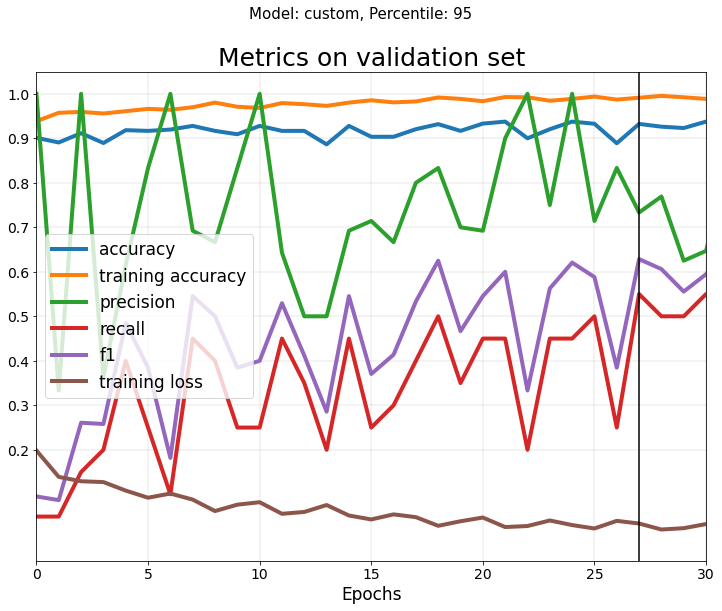

In [16]:
# Let's plot the metrics
metrics = np.load(f'learning_curves/learning_{architecture}_perc{perc_limit}_{locality}.npz')

m_val_f1 = metrics["f1score"]
m_val_f1 = m_val_f1.tolist()
best = m_val_f1.index(np.nanmax(m_val_f1[0:epochs]))
print(f'Best f1 ({m_val_f1[best]}) score in epoch {best+1}')

plt.figure(figsize=(12, 9))
plt.plot(metrics['accuracy'], label= 'accuracy',linewidth=4)
plt.plot(metrics['train_acc'], label= 'training accuracy',linewidth=4)
plt.plot(metrics['precision'], label= 'precision',linewidth=4)
plt.plot(metrics['recall'], label= 'recall',linewidth=4)
plt.plot(metrics['f1score'], label= 'f1',linewidth=4)
plt.plot(metrics['train_loss'], label= 'training loss',linewidth=4)
plt.axvline(x=best, color='black')
plt.title('Metrics on validation set', family='Arial', size=25)
plt.suptitle(f'Model: {architecture}, Percentile: {perc_limit}', size=15)
plt.xlim([0, epochs])
plt.xlabel('Epochs', family='Arial', size=17)
plt.yticks(np.arange(0.2, 1.01, 0.1), fontsize=14)    
plt.xticks(np.arange(0, epochs+1, 5), fontsize=14)
plt.grid(True,linewidth=0.3)
plt.legend(prop={'size': 17})
plt.savefig(f'grafici/Learning_{architecture}_perc{perc_limit}_{locality}_Andrea.png', bbox_inches='tight')    

### **Test**

In [18]:
# Loading model
model.load_state_dict(torch.load(f'models/model_{architecture}_perc{perc_limit}_{locality}.pth', map_location=torch.device('cpu')), strict=False)


running_conf_mat = []

# Just like the validation
for i, (img, lbl) in enumerate(dl_test):

  # To GPU!!!!
  img, lbl = img.cuda(), lbl.cuda()
            
  # We don't need batchnorms 
  model.eval()
            
  # We don't need no gradient as well
  with torch.no_grad():
    out = model(img)
    loss = criterion(out, lbl)
            
  # Saving prediction
  pred = torch.argmax(out, dim=1)


  # Compunting confusion matrix, precision, recall and f1 score
  conf_mat = confusion_matrix(lbl.detach().cpu(), pred.detach().cpu())
  g = np.zeros([2,2])
  if (np.shape(conf_mat) == np.shape(g) ):
    running_conf_mat.append(conf_mat)

# Confusion matrix
conf_mat = np.sum(np.stack(running_conf_mat, axis=0), axis=0)
test_acc = (conf_mat[0,0]+conf_mat[1,1])/(conf_mat[0,0]+conf_mat[1,1]+conf_mat[0,1]+conf_mat[1,0])
test_prec = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])
test_rec = conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])
test_f1 = 2/((1/test_prec)+(1/test_rec))

print(f'ACCURACY:\t{test_acc}')
print(f'PRECISION:\t{test_prec}')
print(f'RECALL:\t{test_rec}')
print(f'F1:\t{test_f1}')      

ACCURACY:	0.9635416666666666
PRECISION:	0.5384615384615384
RECALL:	0.875
F1:	0.6666666666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


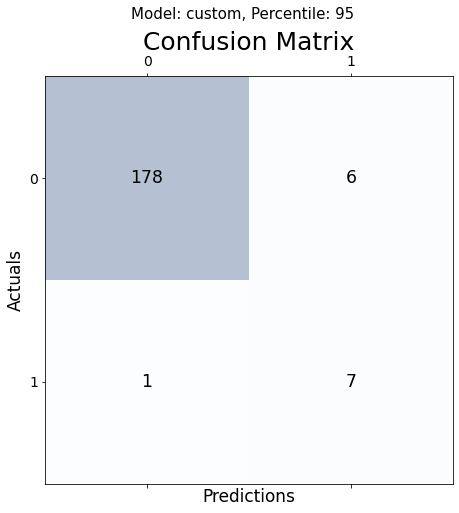

In [19]:
# Plotting confusion matrix
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=17)
plt.ylabel('Actuals', fontsize=17)
plt.title('Confusion Matrix', fontsize=25)
plt.suptitle(f'Model: {architecture}, Percentile: {perc_limit}', fontsize=15, va='bottom')
plt.yticks([0,1], fontsize=14)    
plt.xticks([0,1], fontsize=14)
plt.savefig(f'grafici/Confusion_{architecture}_perc{perc_limit}_{locality}.png', bbox_inches='tight')   

### **Weights visualization**
In this section, the weights of the last layer are reshaped over the starting geometry, in order to see wich parts of the maps contribute more on the classification.  

In [20]:
def WeightShow(model):
    
    '''
    This function reshapes the weights of the last layer for rain and no rain
    outputs.
    '''
    
    # the reshape is different on the architecture
    if architecture == 'report':
        last_fc_weights = model.cpu().fc1.state_dict()['weight']
        dry_weights = torch.tensor(last_fc_weights[0, :])
        rain_weights = torch.tensor(last_fc_weights[1, :])
        dry_weights = dry_weights.view((256,33,33))
        rain_weights = rain_weights.view((256,33,33))
    
    if architecture == 'custom':
        last_fc_weights = model.cpu().fc1.state_dict()['weight']
        dry_weights = torch.tensor(last_fc_weights[0, :])
        rain_weights = torch.tensor(last_fc_weights[1, :])
        dry_weights = dry_weights.view((64,8,8))
        rain_weights = rain_weights.view((64,8,8))

    cam_dry = dry_weights.sum(dim=0)
    cam_dry /= torch.max(cam_dry)
    im_dry = Image.fromarray(np.array(cam_dry))
    im_dry = im_dry.resize((140,140), Image.ANTIALIAS)
    
    cam_rain = rain_weights.sum(dim=0)
    cam_rain /= torch.max(cam_rain)
    im_rain = Image.fromarray(np.array(cam_rain))
    im_rain = im_rain.resize((140,140), Image.ANTIALIAS)

    return np.array(im_dry), np.array(im_rain)

# Calling the funtion
dry, rain = WeightShow(model)

# Saving for local plot (Cartopy doesn't work on colab)
np.savez(f'plot_local/cam_{architecture}_{perc_limit}_{locality}.npz', rain=rain, dry=dry)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


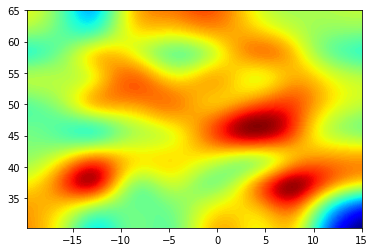

In [22]:
# Plot
lon = np.arange(-19.75, 15.1, 0.25)
lat = np.arange(30.25, 65.1, 0.25)

#rain = np.flip(rain, axis=0)

geojson = geojsoncontour.contourf_to_geojson(
    contourf=plt.contourf(lon,lat,rain,len(rain),cmap=plt.cm.jet),
    fill_opacity=1)

geomap2 = folium.Map([49,0], zoom_start=4, tiles="stamenterrain")

folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.2,
    }).add_to(geomap2)

plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap1)

geomap2